In [1]:
!git clone https://github.com/PraveerT/Multimodal-Fusion.git
import sys
sys.path.insert(1, "/kaggle/working/Multimodal-Fusion")
import CustomArchUniModal,CustomFusionModel,Module_Metrics

Cloning into 'Multimodal-Fusion'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 109 (delta 62), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (109/109), 27.00 KiB | 354.00 KiB/s, done.
Resolving deltas: 100% (62/62), done.


2023-01-29 08:32:46.728053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 08:32:46.814773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 08:32:46.815824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 08:32:46.817996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os,shutil
from tensorflow import keras
from IPython.display import clear_output #clear_output(wait=True)
# plt.style.use('dark_background')
import pickle
import tensorflow as tf
from numpy.random import seed
from IPython.display import FileLink
import os
import json

In [3]:
import tarfile
modalities_imports={"UO":"optical","UM":"mpipe","UR":"radar"}
Modalities={}

for modality in modalities_imports:
    with tarfile.open(f'/kaggle/input/2023-12-gesture-dataset-part-i-preprocessing/{modalities_imports[modality]}.tgz') as t:
        t.extractall('/')
        Modalities[modality]=np.load(f'/kaggle/working/{modalities_imports[modality]}.npy')

In [4]:
from tensorflow.keras.utils import to_categorical
actions=[]
for x in os.listdir('../input/12-hand-gestures/MP_OPTICAL_SMALL'):
    if x.endswith(".npy"):
        # Prints only text file present in My Folder
        actions.append(x)
actions =np.array(actions)
    

label_map = {label:num for num, label in enumerate(actions)}


# 19 videos worth of data
no_sequences = 20

# Videos are going to be 30 frames in length
sequence_length = 30
label_map
print (label_map)
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        labels.append(label_map[action])


y = to_categorical(labels).astype(int)

{'ITALIAN_SPEAK.npy': 0, 'LEFT_HAND_WAVE.npy': 1, 'RIGHT_HAND_WAVE.npy': 2, 'GOOD_TIME.npy': 3, 'TWO_HAND _WAVE.npy': 4, 'EVERYTHING_IS_GOOD.npy': 5, 'COMING_TOGETHER.npy': 6, 'SAME_PAGE.npy': 7, 'REMEMBER.npy': 8, 'BIG_PROBLEM.npy': 9, 'SMALL_PROBLEM.npy': 10, 'REALLY_MEAN.npy': 11}


In [5]:
from sklearn.model_selection import train_test_split

Xo_train,Xo_test,Xm_train,Xm_test,Xr_train,Xr_test,y_train,y_test = train_test_split(Modalities["UO"],Modalities["UM"],Modalities["UR"],y,test_size=0.3)


In [6]:
Models={}
MergeModels={}

for x in range (1,4):
    Models["A_"+str(x)]=CustomFusionModel.A((30,48, 64,3),0.3)
    Models["B_"+str(x)]=CustomFusionModel.B((30,48, 64,3),0.3)
    Models["C_"+str(x)]=CustomFusionModel.C((30,48, 64,3),0.3)
    Models["B_Attention_"+str(x)]=CustomFusionModel.B_Attention((30,48, 64,3),0.3)
    Models["C_Attention_"+str(x)]=CustomFusionModel.C_Attention((30,48, 64,3),0.3)
    
EarlyConfig={"EF-OMR":['A_1','A_2','A_3']}
for Config in EarlyConfig:
    MergeModels[Config]=CustomFusionModel.EarlyMerge(Models[EarlyConfig[Config][0]],Models[EarlyConfig[Config][1]],Models[EarlyConfig[Config][2]],Module_Metrics.initial_learning_rate,Module_Metrics.METRICS)
    MergeModels[Config+"-IA"]=CustomFusionModel.EarlyMergeIntermediateAttention(Models[EarlyConfig[Config][0]],Models[EarlyConfig[Config][1]],Models[EarlyConfig[Config][2]],Module_Metrics.initial_learning_rate,Module_Metrics.METRICS)

MergeConfigs={"IF-OMR":['B_1','B_2','B_3'],"LF-OMR":['C_1','C_2','C_3'],"IF-OMR-IA":['B_Attention_1','B_Attention_2','B_Attention_3'],"LF-OMR-IA":['C_Attention_1','C_Attention_2','C_Attention_3']}
for Config in MergeConfigs:
    MergeModels[Config]=CustomFusionModel.Merge(Models[MergeConfigs[Config][0]],Models[MergeConfigs[Config][1]],Models[MergeConfigs[Config][2]],Module_Metrics.initial_learning_rate,Module_Metrics.METRICS)
LateConfigs={"IF-OMR":['B_1','B_2','B_3'],"LF-OMR":['C_1','C_2','C_3']}
for Config in LateConfigs:
    MergeModels[Config+"-LA"]=CustomFusionModel.Merge_Attention(Models[LateConfigs[Config][0]],Models[LateConfigs[Config][1]],Models[LateConfigs[Config][2]],Module_Metrics.initial_learning_rate,Module_Metrics.METRICS)


EF-OMR


2023-01-29 08:33:03.144012: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-29 08:33:06.459490: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


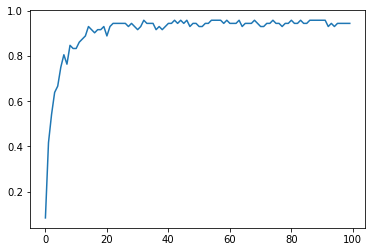

EF-OMR-IA


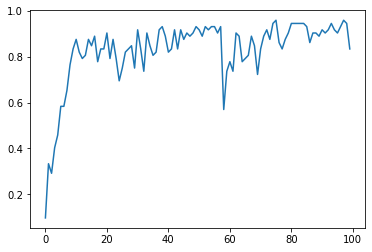

IF-OMR


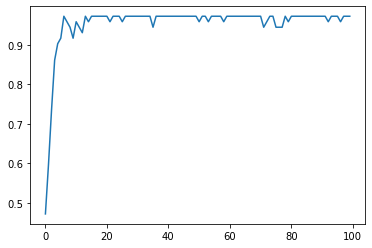

LF-OMR


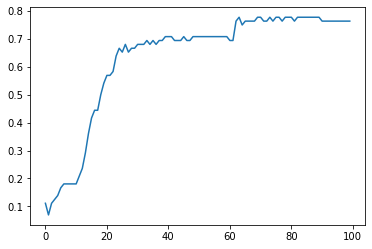

IF-OMR-IA


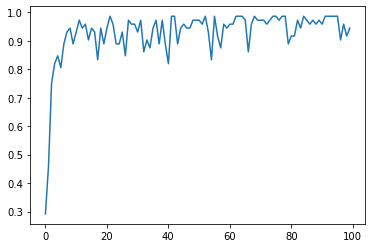

LF-OMR-IA


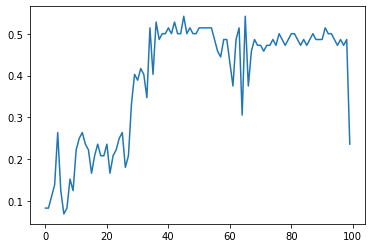

IF-OMR-LA


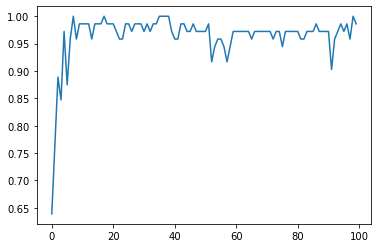

LF-OMR-LA


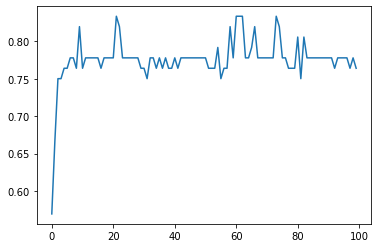

In [7]:
from keras import backend as K

X_train=[Xo_train,Xm_train,Xr_train]
X_test=[Xo_test,Xm_test,Xr_test]

MergeModelHistories={}


for Model in MergeModels:
    print (Model)
    
    checkpoint_cb, early_stopping_cb=Module_Metrics.CE(Model,MergeModels[Model])
    History=MergeModels[Model].fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=1,epochs=100,callbacks=[early_stopping_cb],verbose=0)
    MergeModelHistories[Model]=History.history
    plt.plot(History.history['val_categorical_accuracy'])
    plt.show()
    json.dump(MergeModelHistories, open( "MergeModelHistories.json", 'w' ))
    K.clear_session()
    
    

In [8]:
npy=['optical','mpipe','radar']
for x in npy :
    os.remove(f"/kaggle/working/{x}.npy")